In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
import subprocess as sp
import os
from scipy.ndimage import interpolation,gaussian_filter,affine_transform
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm,Normalize
from photutils import EllipticalAperture,aperture_photometry,\
CircularAperture,EllipticalAnnulus,BoundingBox,ApertureMask
#import pyklip.instruments.SPHERE as sphere
import pyklip.instruments as klip

%matplotlib inline

In [155]:
ADI_tot = np.median(RXJ_ADI,axis = 0)
SDI_tot = np.median(RXJ_SDI,axis= 0)

def azimuthangle():
    regions = np.loadtxt('ds9.txt',delimiter = ',')
    x_uitw = regions[:,0]-145
    y_uitw = regions[:,1]-145
    azimuthangle = np.arccos(x_uitw/np.sqrt((x_uitw)**2+(y_uitw)**2))/np.pi*180
    mask_neg = y_uitw < 0
    azimuthangle[mask_neg] = 360 - azimuthangle[mask_neg]
    return azimuthangle

def wavelbinning(binwidth,data,ext = False):
    data_out = np.zeros((int(np.ceil(len(data[:,0,0])/binwidth)),291,291))
    wavels_mid = np.arange(np.ceil(len(data[:,0,0])/binwidth))*np.nan
    wavels = np.linspace(0.953,1.346,39)
    if ext == True:
        wavels = np.linspace(0.953,1.677,39)
    k = 0
    for i in range(0,len(data[:,0,0]),binwidth):
        data_out[k] = np.nanmedian(data[i:i+binwidth],axis = 0)
        wavels_mid[k] = np.nanmean(wavels[i:i+binwidth])
        k += 1
    return data_out,wavels_mid

def aperbinning(binwidth,data):
    azimuth = azimuthangle()
    data_out = np.zeros((int(np.ceil(len(data[0,:])/binwidth)),len(data[:,0])))
    azimuth_mid = np.arange(np.ceil(len(azimuth[:])/binwidth))*np.nan
    k = 0
    for i in range(0,len(data[0,:]),binwidth):
        data_out[k] = np.nanmedian(data[:,i:i+binwidth],axis = 1)
        azimuth_mid[k] = np.nanmean(azimuth[i:i+binwidth])
        k += 1
    return data_out,azimuth_mid
    
    
def plotbycolor(data,binwidth_color,binwidth_aprs):
    regions = np.loadtxt('ds9.txt',delimiter = ',')
    azimuthangle = np.arccos(regions[:,0]/np.sqrt(regions[:,0]**2+regions[:,1]**2))
    apertures = CircularAperture(regions,  r = 5)
    data,wavels = wavelbinning(binwidth_color,data)
    colorazimut = np.zeros((len(data[:,0,0]),len(regions)))
    colorazimut[:,:] = np.nan
    colorbkg = np.zeros((len(data[:,0,0]),len(regions)))
    colorbkg[:,:] = np.nan
    for i in range(len(data[:,0,0])):
        azimut = aperture_photometry(data[i], apertures)
        bkg = aperture_photometry(interpolation.rotate(data[i],180), apertures)
        colorazimut[i] = azimut['aperture_sum'] 
        colorbkg[i] = bkg['aperture_sum']
    allvalues,azimuthangle_mid = aperbinning(binwidth_aprs,colorazimut)
    allbkg,azimuthangle_mid = aperbinning(binwidth_aprs,colorbkg)
    
    return allvalues,allbkg,wavels,azimuthangle_mid
    
#data_binned,wavels_mid = wavelbinning(2,RXJ_ADI)

3


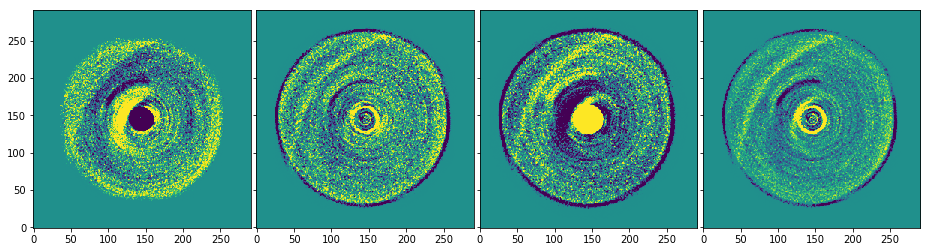

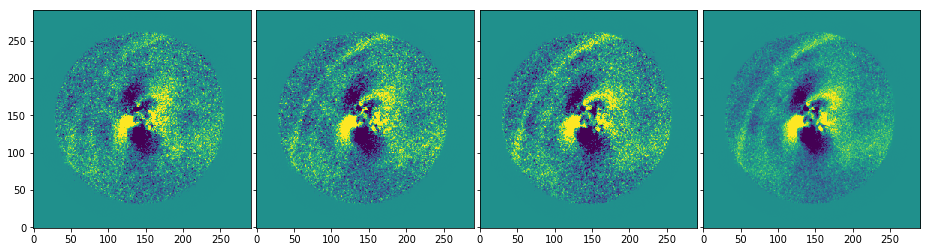

In [272]:
def plotazimuthal(SDI_data,ADI_data,wavelbinning,pointsbinning):
    
    allSDIvalues,allSDIbkg,SDIwavels,azimuthangle = plotbycolor(SDI_data,wavelbinning,pointsbinning)
    allADIvalues,allADIbkg,ADIwavels,azimuthangle = plotbycolor(ADI_data,wavelbinning,pointsbinning)
    totSDIvalues,totSDIbkg,totSDIwavels,azimuthangle = plotbycolor(SDI_data,39,pointsbinning)
    totADIvalues,totADIbkg,totADIwavels,azimuthangle = plotbycolor(ADI_data,39,pointsbinning)

    fig, axes = plt.subplots(1, 4,figsize=(16,3),sharex=True, sharey=True)
    for i in range(len(allSDIvalues[0,:])):
        axes[i].plot(azimuthangle,allSDIvalues[:,i],linewidth = 3, color = 'darkorange',\
                     linestyle = 'solid',label = 'SDI')
        axes[i].plot(azimuthangle,allADIvalues[:,i],linewidth = 3, color = 'darkblue',\
                     linestyle = 'solid',label = 'ADI')
        axes[i].legend()
        axes[i].set_title(r'wavelength: %s $\mu m$' %(round(SDIwavels[i],2)))
    axes[3].plot(azimuthangle,totSDIvalues,linewidth = 3,color = 'darkorange', label = 'SDI')
    axes[3].plot(azimuthangle,totADIvalues,linewidth = 3,color = 'darkblue', label = 'ADI')
    axes[3].legend()
    axes[3].set_title('Entire Y-J range')
    
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel(r'azimuthal angle ($^{o}$)')
    plt.ylabel('flux (arbitrary unit)')
'''
    plt.figure(figsize = (8,5))
    plt.plot(azimuthangle,totSDIvalues,linewidth = 3,color = 'darkorange')
    plt.plot(azimuthangle,totADIvalues,linewidth = 3, color = 'darkblue')
    plt.xlabel(r'azimuthal angle ($^{o}$)')
    plt.ylabel('flux (arbitrary unit)')
'''
def SDI_ADIwavelplot(SDI_data,ADI_data):
    SDI_binned,wavels = wavelbinning(13,SDI_data)
    ADI_binned,wavels = wavelbinning(13,ADI_data)
    fig_SDI, axes_SDI = plt.subplots(1, 4,figsize=(16,4),sharex=True, sharey=True,)
    fig_ADI, axes_ADI = plt.subplots(1, 4,figsize=(16,4),sharex=True, sharey=True)
    print(len(SDI_binned[:]))
    for i in range(len(SDI_binned[:])):
        axes_SDI[i].imshow(SDI_binned[i,:,:],vmax = 1, vmin = -1,origin='lower')
        axes_ADI[i].imshow(ADI_binned[i,:,:],vmax = 1, vmin = -1,origin='lower')
    axes_SDI[3].imshow(SDI_tot,vmax = 1, vmin = -1,origin='lower')
    axes_ADI[3].imshow(ADI_tot,vmax = 1, vmin = -1,origin='lower')
    fig_SDI.subplots_adjust(wspace=0, hspace=0.2)
    fig_ADI.subplots_adjust(wspace=0, hspace=0.2)
    
        
    

#plotazimuthal(RXJ_SDI,RXJ_ADI,13,3)
SDI_ADIwavelplot(RXJ_SDI,RXJ_ADI)

(54,)


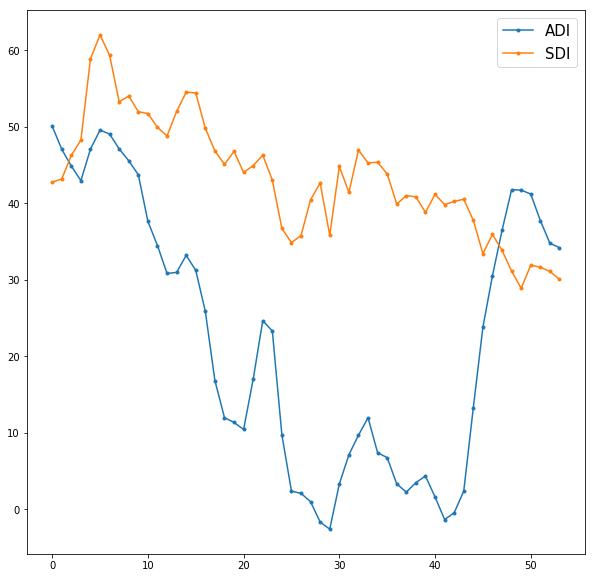

In [48]:
def plotazimuthal(SDI_tot,ADI_tot):
    regions = np.loadtxt('ds9.txt',delimiter = ',')
    apertures = CircularAperture(regions,  r = 6)

    ''' 
    plt.figure(figsize = (12,12))
    plt.imshow(SDI_tot, cmap='summer', origin='lower',vmax = 1,vmin = -1)

    apertures.plot(color='red', lw=3, alpha=0.5)

    plt.figure(figsize = (12,12))
    plt.imshow(ADI_tot, cmap='Greys_r', origin='lower',vmax = 1.5,vmin = -0.7)
    apertures.plot(color='red', lw=3, alpha=0.5)
    #plt.savefig('azimuthalapertures.png')

    plt.figure(figsize = (12,12))
    plt.imshow(interpolation.rotate(SDI_tot,180),cmap='Greys_r', origin='lower',vmax = 1.5,vmin = -0.7)
    apertures.plot(color='red', lw=3, alpha=0.5)
    '''

    ADI_azimut = aperture_photometry(ADI_tot, apertures)
    print(np.shape(ADI_azimut))
    SDI_azimut = aperture_photometry(SDI_tot, apertures)
    ADI_bkg = aperture_photometry(interpolation.rotate(ADI_tot,180), apertures)
    SDI_bkg = aperture_photometry(interpolation.rotate(SDI_tot,180), apertures)

    plt.figure(figsize = (10,10))
    plt.plot(ADI_azimut['aperture_sum'],marker = 'o',label = 'ADI',markersize = 3)
    plt.plot(SDI_azimut['aperture_sum'],marker = 'o',label = 'SDI',markersize = 3)
    #plt.plot(ADI_bkg['aperture_sum'],marker = 'o',label = 'ADI_bkg',markersize = 3)
    #plt.plot(SDI_bkg['aperture_sum'],marker = 'o',label = 'SDI_bkg',markersize = 3)
    #plt.plot(SDI_azimut['aperture_sum'] - SDI_bkg['aperture_sum'], marker = 'o',label = 'phasefunc',markersize = 3)
    #plt.ylim(ymax = 100)
    plt.legend(fontsize = 15)

    #print(thetas)
    #plt.savefig('azimuthal_flux_all.png')
plotazimuthal(SDI_tot,ADI_tot)

In [31]:
def signalerror(mask,data,aperture):
    mask_area = np.ones_like(data)
    area = aperture_photometry(mask_area, aperture, mask = mask)
    sgn = aperture_photometry(ADI_tot, aperture, mask = mask)
    mean = sgn['aperture_sum']/area['aperture_sum']
    stdef_inter = aperture_photometry((data-mean)**2, aperture, mask = mask)
    stdef = np.sqrt(1./area['aperture_sum']*stdef_inter['aperture_sum'])
    toterr = stdef * area['aperture_sum']
    return stdef,toterr

def flux(data,mask = False):
    mask_non,mask_with,aperture = sgnapertures()
    phot_table_sgn = aperture_photometry(data, aperture, mask = mask_with)
    phot_table_bkg = aperture_photometry(data, aperture, mask = mask_non)
    if mask == True:
        return phot_table_sgn['aperture_sum'],phot_table_bkg['aperture_sum'],mask_non,mask_with,aperture
    return phot_table_sgn['aperture_sum'],phot_table_bkg['aperture_sum']

def printsgnval(data):
    sgn,bkg,mask_non,mask_with,aperture = flux(data,mask = True)
    stdef,toterr = signalerror(mask_with,data,aperture)
    stdef_bkg,toterr_bkg = signalerror(mask_non,data,aperture)
    print('signal \n',sgn)
    print('\n stdef signal \n',stdef)
    print('\n total error signal \n',toterr)
    print('\n \n background \n',bkg)
    print('\n stdef background \n',stdef_bkg)
    print('\n total error signal \n',toterr_bkg)

    
printsgnval(SDI_tot)

signal 
    aperture_sum   
------------------
1244.5170082450777

 stdef signal 
    aperture_sum   
------------------
0.6149938511466847

 total error signal 
    aperture_sum   
------------------
1083.3970848425852

 
 background 
   aperture_sum  
----------------
895.069746645325

 stdef background 
    aperture_sum   
------------------
0.7551605503352318

 total error signal 
    aperture_sum   
------------------
1330.3201931138897


In [3]:
def sgnapertures():
    positions = [(145., 145.)]
    a_in = 118.
    a_out = 129.
    b = 82.
    theta = np.pi / 180. * 52
    aperture = EllipticalAnnulus(positions,a_in,a_out,b,theta)

    mask_non = np.zeros_like(ADI_tot,dtype = 'bool')
    mask_non[:,:] = True
    mask_non[:200,110:] = False

    mask_with = np.zeros_like(ADI_tot,dtype = 'bool')
    mask_with[:,:] = True
    mask_with[-200:,:-110] = False
    return mask_non,mask_with,aperture

In [4]:
def filenames(path,exclude):
    dirs = science_names(path)
    all_filenames = []
    for j in range(len(dirs)):
        filenames_all = os.listdir('%s/%s'%(path,dirs[j]))  
        filenames = []
        for i in range(len(filenames_all)):
            if not filenames_all[i].endswith(exclude):
                filenames.append(filenames_all[i])
        all_filenames.append(sorted(filenames))
    
    return np.array(all_filenames)

def dopen(path,exclude):
    files = filenames(path,exclude)
    dirs = science_names(path)
    data_out = np.zeros((len(files[:,0]),39,291,291))
    headers = []
    for i in range(len(files[:,0])):
        data_intermed = np.zeros((len(files[0]),39,291,291))
        for j in range(len(files[0])):
            data, head = fits.getdata('%s/%s/%s' %(path,dirs[i],files[i,j]), header=True)
            data_intermed[j] = data
        data_out[i] = np.median(data_intermed,axis = 0)
        headers.append(head)
    return data_out,headers

def open_all(dataset,cent = False, header = False):
    if dataset == 'RXJ':
        excludedata = 'DR_4.fits'
        excludecenter = 'DR_2.fits'
        path = 'reducedRXJ'
        
    if dataset == 'crdata':
        excludedata = 'Calibration_IFS_SCIENCE_DR.fits'
        excludecenter = excludedata
        path = 'reducedcorodata'
    
    if cent == True:
        path = '%s/starcenter' %(path)
        starcent,starcenthe = dopen(path = path,exclude = excludecenter)
        return starcent        
    data,he = dopen(path = path,exclude = excludedata)
    if header == True:
        return he
    return data,he

#names = filenames('reducedRXJ/starcenter',exclude = 'DR_2.fits',cent = False)
#starcent,starcenthe = dopen('reducedRXJ',exclude = 'DR_2.fits',cent = True)
#print(names)
#RXJ,RXJhe = dopen('reducedRXJ',exclude = 'DR_4.fits')
#print(names)

In [5]:
def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def extractdata(name,path):
    data = fits.open('%s/%s' %(path,name))
    data = data[0].data
    return data

def science_names(path,header = False):        
    all_filenames = os.listdir(path)
    filenames = []
    for i in range(len(all_filenames)):
        if all_filenames[i].startswith('SPHER'):
            filenames.append(all_filenames[i])
               
    if header == True:
        header_names = []   
        for j in range(len(filenames)):
            if filenames[j].endswith('000.fits'):
                header_names.append(filenames[j])
        return sorted(header_names)
    else:
        return sorted(filenames)
    
def opendatamedian(path,number_cubes):
    namelist = science_names(path)
    data_total = np.zeros(((int(len(namelist)/number_cubes)),39,291,291))
    data_intermed = np.zeros((number_cubes,39,291,291))
    k = 0
    for file in range(len(namelist)):
        data_intermed[k,:,:,:] = extractdata(namelist[file],path)
        k += 1
        if k == number_cubes:
            data_total[int(file/number_cubes),:,:,:] = np.median(data_intermed,axis = 0)
            k = 0
    print(np.shape(data_total))
    return data_total

def opencenter(path):
    path = '%s/reducedcenter' %(path)
    names = science_names(path)
    data = np.zeros((len(names),39,291,291))
    for name in range(len(names)):
        data[name,:,:,:] = extractdata(names[name],path)
    return data

def extractheader(line,name,path):
    data = fits.open('%s/%s' %(path,name))
    value = data[0].header[line]
    return value

In [6]:
def singleplot(data,vmin = 0,vmax = 100,name = None,lognorm = False,cutmin = 0,cutmax = 291,\
               save = False, color = None,xc = 145,yc = 145, center = False, interpolation = 'nearest'):
    '''shows a single 2d image, if center = true, a small circle is added around the center of the image ''' 
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    if lognorm == True:
        norm = LogNorm(vmin = vmin, vmax = vmax)
    else:
        norm = Normalize(vmin = vmin, vmax = vmax)

    im = ax.imshow(data, cmap = color,norm = norm, origin='lower')
    ax.set_ylim(cutmin,cutmax)
    ax.set_xlim(cutmin,cutmax)
    
    if center == True: #adds a circle around the center pixel
        circ = plt.Circle((xc,yc),4,fill = False,color = 'white') 
        plt.gca().add_artist(circ)
        
    cbaxes = fig.add_axes([0.91, 0.125, 0.025, 0.775]) #position and width of the colorbar
    cb = plt.colorbar(im, cax = cbaxes)
    
    if save == True:
        plt.savefig('%s.png' %(name))

In [7]:
def center_coordinates(data, amplit = False):
    '''fits a gaussian over non coronografic data and determines the position of the center'''
    
    cutmin,cutmax = 100,190 #small square around the star to avoid taking the edge into account 
    y, x = np.mgrid[:cutmax-cutmin, :cutmax-cutmin]
    data = data[cutmin:cutmax,cutmin:cutmax]
    p_init = models.Gaussian2D(x_mean = (cutmax-cutmin)/2, y_mean = (cutmax-cutmin)/2,x_stddev = 2,y_stddev = 2)
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x,y, data)
    xcoord = p.parameters[1]+cutmin
    ycoord = p.parameters[2]+cutmin
    ampl = p.parameters[0]
    if amplit == False:
        return xcoord,ycoord
    return ampl

def centercoro(datacenteruse,dist = False,ampl = False):
    '''determines the center of an individual centerframe, if ampl == True,
    it returns a cube with all the spots of the raw data, which can be used to 
    calculate the wavelength dependend througput'''
    
    centerx,centery = [108,95,175,190],[191,110,95,178] #
    width = 15
    coordinates = np.zeros((4,2))
    data_end = np.zeros((291,291))
    
    rawspots = np.zeros((4,2*width,2*width))
    for i in range(4):
        y, x = np.mgrid[:width*2, :width*2]
        smoothed_center = gaussian_filter(datacenteruse,sigma = 25)
        extracted_smooth = datacenteruse-smoothed_center
        datafirst = extracted_smooth[centerx[i]-width:centerx[i]+width,centery[i]-
                                     width:centery[i]+width]
        maximum = np.unravel_index(datafirst.argmax(), datafirst.shape)
        newcenter = [centerx[i]+maximum[0]-width,centery[i]+maximum[1]-width]
        data = extracted_smooth[newcenter[0]-width:newcenter[0]+width,
                                newcenter[1]-width:newcenter[1]+width]
        rawspots[i] = datacenteruse[newcenter[0]-width:newcenter[0]+width,newcenter[1]-width:newcenter[1]+width]
        p_init = models.Gaussian2D(x_mean = width, y_mean = width, 
                                   x_stddev = 1.5, y_stddev = 1.5)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init,x,y, data)
        coordinates[i,0] = p.parameters[1]+newcenter[0]-width
        coordinates[i,1] = p.parameters[2]+newcenter[1]-width
        data_end[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]= p(x, y)
    middel = np.mean(coordinates,axis = 0)
    distance1 = np.sqrt(np.sum((coordinates[1,:]-coordinates[3,:])**2))
    distance2 = np.sqrt(np.sum((coordinates[0,:]-coordinates[2,:])**2))
    if dist == True:
        return distance1,distance2
    elif ampl == True:
        return middel[0],middel[1],rawspots
    else:
        return middel[0],middel[1]

def corocentercoordinate(centerdata,ampl=True):
    '''determines the precise center by combining mutiple centering frames, if ampl == True, 
    it returns the median amplitude of the spots in each wavelength, for scaling in the SDI routine'''
    
    coordinates = np.zeros((len(centerdata[:,0,0,0]),39,2))
    mask = imcon(np.zeros((30,30)),0,5,15,15)
    mask = np.ones((4,30,30),dtype = 'int')*mask
    
    if ampl == True:
        spots = np.zeros((len(centerdata[:,0,0,0]),39))
        for data in range(len(centerdata[:,0,0,0])):
            for waveldata in range(len(centerdata[0,:,0,0])):
                coordinates[data,waveldata,0],coordinates[data,waveldata,1],rawspot \
                    = centercoro(centerdata[data,waveldata,:,:],ampl = True)
                spots[data,waveldata] = np.median(rawspot[mask])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return np.median(spots,axis = 0)
    
    else:
        for data in range(len(centerdata[:,0,0,0])):
                for waveldata in range(len(centerdata[0,:,0,0])):
                    coordinates[data,waveldata,0],coordinates[data,waveldata,1]\
                        = centercoro(centerdata[data,waveldata,:,:])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return coordinates_mdn[0],coordinates_mdn[1]

def imcon(im,r_min,r_max,xc, yc):
    '''returns a mask that selects a donut with inner radius r_min, outer radius r_max, with center xc,yc'''
    
    ny, nx = np.shape(im)
    yp, xp = np.mgrid[:ny, :nx]
    yp = yp-yc
    xp = xp-xc
    rmap = np.sqrt(xp**2 + yp**2)
    mask = (rmap <= r_max) * (rmap >= r_min)
    return mask

def shift_center(data,xcoord,ycoord):
    '''shifts an image from center xcoord,ycoord to the center of the image, 145,145'''
    
    data_shifted = interpolation.shift(data,[145-ycoord,145-xcoord])
    return data_shifted

def shift_center_all(dataset,coro = False):
    '''centers all data in the cube'''
    
    if coro == True:
        data,he = open_all(dataset = dataset)
        centerdata = open_all(dataset = dataset,cent = True)
        center_y,center_x = corocentercoordinate(centerdata,ampl = False) 
    shifted_data = np.zeros_like(data)
    for i in range(len(data[:,0,0,0])):
        if coro == False:
            center_x,center_y = center_coordinates(data[i,4,:,:])
        for j in range(39):
            shifted_data[i,j,:,:] = shift_center(data[i,j,:,:],center_x,center_y)
    return shifted_data,he

In [8]:
RXJ_sh,RXJ_he = shift_center_all(dataset = 'RXJ',coro = True)
#crdata_sh,crdata_he = shift_center_all(dataset = 'crdata',coro = True)

In [34]:
def scaling(im, sca, order=2):
    '''scales the image im with given scale sca'''
    
    center = np.array([145,145])
    if sca == 1:
        return(im)
    scale = np.array([[1./sca,0],[0,1./sca]])
    offset_combined = center - center.dot(scale)
    dst=affine_transform(im,scale.T, order=order, offset=offset_combined, output_shape=(291,291), cval=0.0)
    return(dst)

def descale(imin, scalefac):
    '''scales imin at all wavelengths with their scalefactor scalefac, which is an array'''
    
    nim, nx, ny = imin.shape
    sx = np.ones_like(scalefac) * 145
    sy = np.ones_like(scalefac) * 145
    im_out = np.zeros((nim, nx, ny))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = scaling(frame_sq, scalefac[j],)
        im_out[j,:,:] = frame_rot  
    return(im_out)

def rotate(data,headers):
    '''rotates the image with the parallactic angle, which is taken from the header'''
    signal_rotated = np.zeros_like(data)
    for file in range(len(data[:,0,0,0])):
        header = headers[file]
        angle = header['HIERARCH ESO TEL PARANG START']
        for wavel in range(len(data[0,:,0,0])):
            signal_rotated[file,wavel,:,:] = interpolation.rotate(data[file,wavel,:,:],\
                                                                  angle*(-1)-135.99+100.48,reshape = False)
    return signal_rotated

def AOnorm(data,r_min,r_max,mag):
    '''corrects for the difference in AO correction between the different cubes, 
    it returns the median of a certain selection of the background, which can be used to scale the images'''
    
    norm = np.zeros((len(data[:,0,0,0]),39))
    for j in range(len(data[:,0,0,0])):
        for i in range(39):
            mask = imcon(data[j,i],r_min/mag[i],r_max/mag[i],145, 145)
            norm[j,i] = np.median(data[j,i,mask])
    norm = np.median(norm,axis = 1)
    return norm

def magnification(ext = True,stop = 39):
    if ext == True:
        wavels = np.linspace(0.953,1.677,39)
        
    else: 
        wavels = np.linspace(0.953,1.346,39)    
    mag = wavels[stop-1]/wavels
    return mag

def ADI_new(data,headers,dataset,ext = False):
    mag = magnification(ext = ext)
    #norm = np.mean(RXJ_sh,axis = (1,2,3))-np.mean(RXJ_sh)
    norm = AOnorm(data,55,110,mag)
    norm = norm/np.median(norm)
    data_norm = data/norm[:,None,None,None]
    norm2 = AOnorm(data_norm,55,80,mag)
    signal = np.zeros((39,291,291))
    
    #print('start with wavelengthbin No. %s' %(i))
    
    median_bg = np.median(data_norm,axis = 0)
    med_sub = rotate((data_norm-median_bg),headers = headers)
    signal = np.median(med_sub,axis = 0)
    return signal#,norm,median_bg,med_sub,data_norm,norm2
    #wfits(signal, 'signal.fits')

def SDI(data,start,stop,dataset,headers,coro = True,ext = False,ASDI = False):
    '''Applies SDI on the given data, for the wavelengthrange start to stop.'''
    
    centerdata = open_all(dataset = dataset,cent = True)
    mag = magnification(ext = ext,stop = stop)

    if coro == True:
        norm = AOnorm(data,50,75,mag)
        amplitudes = corocentercoordinate(centerdata,ampl=True)
    else:
        norm = AOnorm(data,40,80,mag)
        amplitudes = np.zeros((39))
        for k in range(39):
            mask = imcon(data[0,0,:,:],7./mag[k],20./mag[k],145,145)
            amplitudes[k] = np.median(data[:,k,mask])

    norm = norm/np.median(norm)
    data = data/norm[:,None,None,None]
    sdi_out = np.zeros((len(data[:,0,0,0]),stop-start,291,291))
    sdi_norm = np.zeros_like(sdi_out)
    descaled = np.zeros_like(sdi_out)
    mask = imcon(data[0,0,:,:],55,80,145,145)
    amplitudes = amplitudes/np.median(amplitudes)
    
    for i in range(len(data[:,0,0,0])):
        descaled[i] = descale(data[i,start:stop,:,:], mag[start:stop]) 

    amplitudes = np.median(descaled[:,:,mask],axis = (0,2))   
    amplitudes = amplitudes/np.median(amplitudes)
    sdi_norm = descaled/amplitudes[None,:,None,None]
    if ASDI == False:
        sdi_norm = rotate(sdi_norm,headers = headers)
    
    mask_nan = abs(sdi_norm) < 0.01
    sdi_norm[mask_nan] = np.nan
    ref = np.nanmedian(sdi_norm,axis = 1)
    
    
    sdi_norm_sub = sdi_norm - ref[:,None,:,:]
    sdi_norm_sub[mask_nan] = 0
    
    
    for k in range(len(data[:,0,0,0])):
        sdi_out[k] = descale(sdi_norm_sub[k],1./mag[start:stop])
    
    if ASDI == True:
        sdi_out = rotate(sdi_out,headers = headers)
    #rotated_sdi = rotate(sdi_out,headers = headers)
    sdi_final = np.median(sdi_out*amplitudes[None,:,None,None],axis = 0)
    return sdi_final

In [35]:
RXJ_SDI = SDI(RXJ_sh,0,39,coro = True,ext = False, dataset = 'RXJ',headers = RXJ_he)
print('hi, I am finished :)')
#RXJ_ADI = ADI_new(RXJ_sh,dataset = 'RXJ',ext = False,headers = RXJ_he)

#crdata_SDI,norm_cr,amplitudes_cr = SDI(crdata_sh,0,39,coro = True,ext = False,\
#                                       dataset = 'crdata',headers = crdata_he)

/home/ardjan/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


hi, I am finished :)


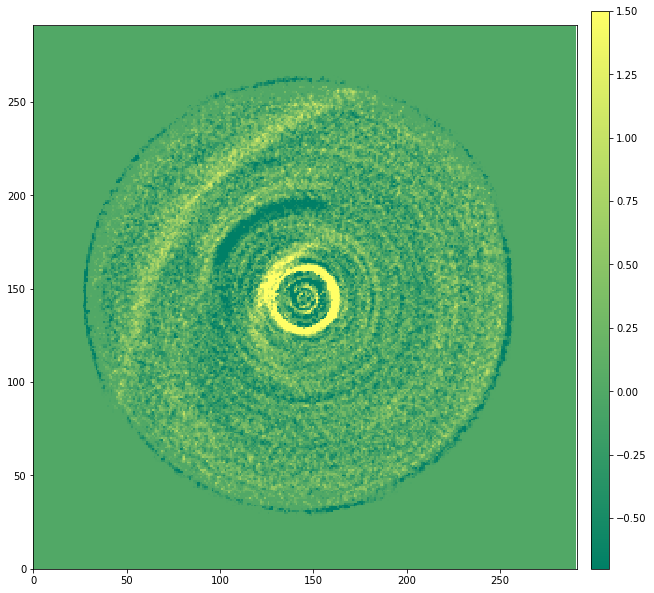

In [32]:
wfits(RXJ_SDI[1],'zoomed_cube.fits')
hoihoi = RXJ_SDI[0]
hoihoimed = np.median(hoihoi,axis = 0)
singleplot(hoihoimed, vmax = 1.5, vmin = -0.7, color = 'summer')

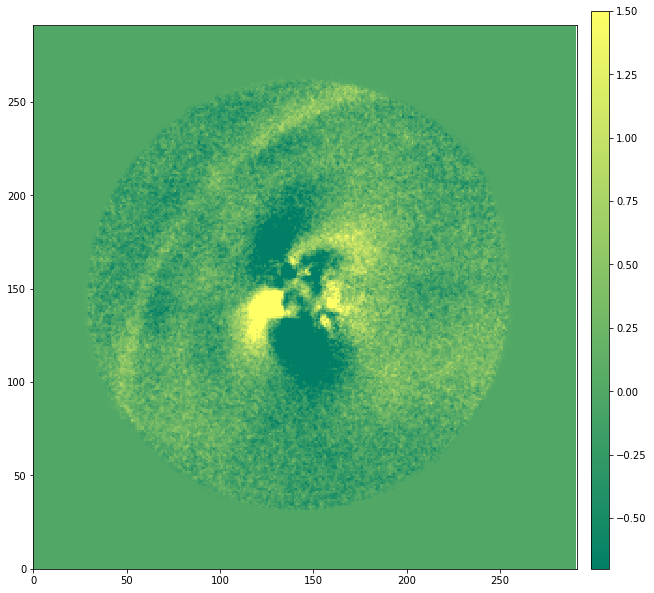

In [33]:
#singleplot(np.median(RXJ_SDI[:,:],axis = (0,1)),name = 'RXJ_SDI_J_divmean',save = \
#           False,vmin = -2,vmax = 1.5, color = 'viridis')
singleplot(np.median(RXJ_ADI[0:39],axis = 0),vmin = -0.7,vmax = 1.5, color = \
           'summer',name = 'RXJ_ADI_all_higher',save = False)

In [43]:
#HD_SDI,xx = SDI('28-3/allwithcor',HD_sh,0,38)
RXJ_SDI,yy,amplitudes = SDI('RXJ',RXJ_sh,0,39)

In [10]:
def showcorosmooth():
    '''shows the coronografic data, smoothed with a gaussian. 
    This is just to show an intermediate step and is not used in the rest of the program'''
    
    datacenter = opencenter()
    showdata_wavel(datacenter[0,:,:,:],'coronodata1',-10,250)
    smoothed_center = gaussian_filter(datacenter[0,:,:,:],sigma = 25)
    extracted_smooth = datacenter[0,:,:,:]-smoothed_center
    showdata_wavel(extracted_smooth,'smoothedcorono1',-10,200)

def headervalue_all(path):
    '''prints all values for a certain header value in the assigned map, this is just 
    for checking which files are in the correct mode and is not used in the rest of the program'''
    
    names = science_names(path)
    for name in range(len(names)):
        #wavelmax = extractheader('HIERARCH ESO DRS IFS MAX LAMBDA',names[name],path)
        mode = extractheader('HIERARCH ESO INS4 MODE',names[name],path)
        exptime = extractheader('EXPTIME',names[name],path)
        objct = extractheader('OBJECT',names[name],path)
        print(mode,exptime,objct,names[name])
        
def showmodelcorocenter():
    datacenter = opencenter()
    datacenteruse = datacenter[0,21,:,:]
    centerx,centery = [108,95,175,190],[191,110,95,178]
    width = 20
    data_end = np.zeros((291,291))
    coordinates = np.zeros((4,2))
    for i in range(4):
        y, x = np.mgrid[:width*2, :width*2]
        smoothed_center = gaussian_filter(datacenteruse,sigma = 25)
        extracted_smooth = datacenteruse-smoothed_center
        datafirst = extracted_smooth[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]
        #plt.imshow(datafirst)
        #plt.figure()
        maximum = np.unravel_index(datafirst.argmax(), datafirst.shape)
        newcenter = [centerx[i]+maximum[0]-width,centery[i]+maximum[1]-width]
        data = extracted_smooth[newcenter[0]-width:newcenter[0]+width,
                                newcenter[1]-width:newcenter[1]+width]
        print(maximum)

        p_init = models.Gaussian2D(x_mean = width, y_mean = width, 
                                   x_stddev = 1.5, y_stddev = 1.5)
        #print(p_init)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init,x,y, data)
        coordinates[i,0] = p.parameters[1]+newcenter[0]-width
        coordinates[i,1] = p.parameters[2]+newcenter[1]-width

        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(data, origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(data - p(x, y), origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Residual")
        data_end[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]= p(x, y)
        #print(p)
    #print(coordinates)
    middel = np.mean(coordinates,axis = 0)
    plt.figure()
    plt.imshow(extracted_smooth,vmin = -50, vmax = 100)
    print(middel)
    print(coordinates)
    plt.figure()
    plt.imshow(data_end)
    plt.savefig('fit coro data')
    plt.figure()
    plt.imshow(datacenteruse,vmin = -10, vmax = 200)

def showdata_number(data,name,vmins,vmaxs,save = False,lognorm = False,cutmin = 70,cutmax = 220):
    '''shows the data over time'''
    
    fig, axes = plt.subplots(4, 4,figsize=(16,16),sharex=True, sharey=True)
    
    if lognorm == True:
        color = LogNorm(vmins, vmaxs)
    else:
        color = Normalize(vmins,vmaxs)
        
    for number in range(len(data[:,0,0])):
        data_per_number = data[number,:,:]
        ypos = number%4
        xpos = np.int(number/4)
        axes[xpos, ypos].imshow(data_per_number,norm = color,origin='lower')
        axes[xpos, ypos].set_title(number)
    median_value = np.median(data, axis = 0)
    mean_value = np.mean(data, axis = 0)
    #im = axes[1,2].imshow(median_value)
    #axes[1,2].set_title('median')
    #axes[2,3].imshow(mean_value)
    #axes[2,3].set_title('mean')
    fig.subplots_adjust(wspace=0, hspace=0.10)
    #fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Cube number dependence', fontsize = 25, x = 0.43)
    #plt.axis([cutmin, cutmax, cutmin, cutmax])
    plt.savefig('number dependence %s.jpg' %(name))
    plt.show()

def showdata_wavel(data, vmins,vmaxs, name = 'name',save = False,lognorm = False,cutmin = 0,cutmax = 291,\
                   ext = True): 
    '''#gives an image with at each subplot an image in a different wavelength bin'''
    
    fig, axes = plt.subplots(5,8,figsize=(16,9.5),sharex=True, sharey=True)
    if lognorm == True:
        color = LogNorm(vmins, vmaxs)
    else:
        color = Normalize(vmins,vmaxs)
    wavelmax = 1.677
    if ext == False:
        wavelmax = 1.346
    wavelengthvalue = np.linspace(0.953,wavelmax,39)
    xas_ticks = 4
    
    for wavelengthbox in range(39):
        data_used = data[wavelengthbox]
        ypos = wavelengthbox%8
        xpos = np.int(wavelengthbox/8)
        axes[xpos,ypos].imshow(data_used,label = wavelengthvalue[wavelengthbox],norm = color,origin='lower')
        axes[xpos, ypos].set_title(r'%s$\mu m$' %(round(wavelengthvalue[wavelengthbox],3)))
        
    fig.subplots_adjust(wspace=0, hspace=0.2)#space between subplots
    
    median_value = np.median(data, axis = 0)
    im = axes[4,7].imshow(median_value,norm = color,origin='lower')
    axes[4,7].set_title('median')
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Wavelength dependence', fontsize = 25, x = 0.43)
    plt.xticks(np.round(np.linspace(cutmin,cutmax,xas_ticks),0)) #cosmetics for the x-axis values
    if save == True:
        plt.savefig('wavelength dependence %s.jpg' %(name))
    plt.show()

def plotspecklegrowth():
    '''plots the growth of the speckles over wavelength'''
    
    data = opencenter()
    growthindiv = np.zeros((4,39))
    distance1,distance2 = np.arange(39),np.arange(39) 
    for j in range(4):
        for i in range(len(data[0,:,0,0])):    
            distance1[i],distance2[i] = centercoro(data[j,i,:,:],dist = True)
        growthindiv[j,:] = (distance1/distance1[0] + distance2/distance2[0])/2. 
    growth = np.median(growthindiv,axis = 0)

    x = np.linspace(0.953,1.346,39)/0.953
    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x-1, growth-1)
    a2,_,_,_ = np.linalg.lstsq(x, growth)
    print(a)
    print(a2)

    plt.figure(figsize=(12, 9))
    plt.plot(np.linspace(0.953,1.346,39)/0.953,growth, label = 'data')
    plt.plot(np.arange(0,1.5,0.1),np.arange(0,1.5,0.1),label = 'expected slope')
    #plt.plot(np.arange(1,1.5,0.1),a*np.arange(1,1.5,0.1)+(1-a), label = 'fit with fixed end with slope %s' 
    #         %(np.round(a[0],3)))
    plt.plot(np.arange(1,1.5,0.1),a2*np.arange(1,1.5,0.1), label = 'fit with slope %s' 
             %(np.round(a2[0],3)))
    plt.legend(loc = 'upper left')
    plt.axis([1,1.4,1,1.4])
    plt.ylabel('relative growth in speckle width')
    plt.xlabel('relative growth in wavelength')
    plt.savefig('specklegrowth.png')
    plt.grid()
    
def show_centerfit(): 
    '''shows a plot of the fitted gaussian that is used to determine the 
    position of the center of the star. The residual is also plotted.'''
    
    cutmin,cutmax = 100,190
    y, x = np.mgrid[:cutmax-cutmin, :cutmax-cutmin]

    data = noncorodata[9,1,:,:]
    data = data[cutmin:cutmax,cutmin:cutmax]
    p_init = models.Gaussian2D(x_mean = (cutmax-cutmin)/2, y_mean = (cutmax-cutmin)/2, x_stddev = 1,y_stddev = 1)
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x,y, data)

    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    plt.imshow(data, origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Data")
    plt.subplot(1, 3, 2)
    plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Model")
    plt.subplot(1, 3, 3)
    plt.imshow(data - p(x, y), origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Residual")

    xcoord = p.parameters[1]
    ycoord = p.parameters[2]

    print('mean of residual =', np.mean(data - p(x, y)))
    print('median of residual =',np.median(data - p(x, y)))
    print('xcoord =',xcoord,'ycoord =', ycoord)

    print(p_init)
    print(p)
    plt.savefig('gaussian non coro fit.jpg')
    
def opendata(path,number_cubes):
    '''opens all data in a 5D array, is currently unused, since the files are too big to handle'''
    
    namelist = science_names(path)
    data_total = np.zeros(((int(len(namelist)/number_cubes)),number_cubes,39,291,291))
    for file in range(len(namelist)):
        data_per_number = extractdata(namelist[file],path)
        data_total[int(file/number_cubes),file%number_cubes,:,:,:] = data_per_number
    print(np.shape(data_total))
    return np.median(data_total,axis = 1)

In [339]:
def header_to_array(path,value):
    names = science_names(path)
    data = np.empty(np.shape(names))
    for name in range(len(names)):
        data[name] = extractheader(value,names[name],path)   
    return data


        #wavelmax = extractheader('HIERARCH ESO DRS IFS MAX LAMBDA',names[name],path)
        #mode = extractheader('HIERARCH ESO INS4 MODE',names[name],path)
        #exptime = extractheader('EXPTIME',names[name],path)
        #objct = extractheader('OBJECT',names[name],path)
        #print(mode,exptime,objct,names[name])
        
    
#from astropy.table import Table
#t = Table([[1, 2], [4, 5], [7, 8]], names=('a', 'b', 'c'))


#t
#t.write('table1.fits', format='fits')

In [346]:
path = 'RXJ/science'
filenames = science_names(path)
dit = header_to_array(path,'HIERARCH ESO DET SEQ1 DIT')
ndit = header_to_array(path,'NAXIS3')/4
pupoff = np.ones(np.shape(filenames))*(135.99 - 100.48)
print(pupoff)

[35.51 35.51 35.51 35.51 35.51 35.51 35.51 35.51 35.51 35.51 35.51 35.51
 35.51 35.51 35.51 35.51]


In [3]:
'''This block is used to run the esorex reduction pipeline'''

def filenames(path): 
    '''loads the filenames out of each folder'''
    
    directories = ['darks','detectorflats','instrumentflats','specpos',
                   'wavecal','distortmap','science','refstar','preampflat']
    names = []
    for directory in range(len(directories)):
        names.append(sorted(os.listdir("%s/%s" %(path,directories[directory]))))
    return names

def corr(name,values): 
    '''corrects the wavelengthcalibration and spectral positioning file to third order, since the
    pipeline has struggles to do it good at once'''
    
    with fits.open(name, mode='update') as hdul:
        data = hdul[0].data
        mask = data > 0
        data[mask] = data[mask]+values[0]*data[mask]**3+values[1]*data[mask]**2+values[2]*data[mask]+values[3]
        hdul[0].data = data
        hdul.flush()  # changes are written back to the original file

def configcommands(): 
    '''creates commandlines for all calibration data, which are suitable for configuration files'''
    
    path = 'IFS'
    names = filenames(path)
    
    #commandlines for raw data
    darks_raw = ['%s/darks/' %(path) + i + ' IFS_DARK_RAW' for i in names[0]]
    detectorflats_raw = ['%s/detectorflats/' %(path) + i + ' IFS_DETECTOR_FLAT_FIELD_RAW' 
                         for i in names[1]]
    instrumentflats_raw = ['%s/instrumentflats/' %(path) + i + ' IFS_FLAT_FIELD_RAW' 
                           for i in names[2]]
    specpos_raw = ['%s/specpos/' %(path) + i + ' IFS_SPECPOS_RAW' for i in names[3]]
    wavecal_raw = ['%s/wavecal/' %(path) + i + ' IFS_WAVECALIB_RAW' for i in names[4]]
    distortmap_raw = ['%s/distortmap/' %(path) + i + ' IFS_DISTORTION_MAP_RAW' 
                      for i in names[5]]
    science_raw = ['%s/science/' %(path) + i + ' IFS_SCIENCE_DR_RAW' for i in names[6]]
    refstar_raw = ['%s/refstar/' %(path) + i + ' IFS_SCIENCE_DR_RAW' for i in names[7]]
    preampflat_raw = ['%s/preampflat/' %(path) + i + ' IFS_DETECTOR_FLAT_FIELD_RAW' for i in names[8]]
    
    #commandlines for reduced calibration data
    master_dark = 'master_dark.fits IFS_MASTER_DARK'
    badpixelmap = 'static_badpixels.fits IFS_STATIC_BADPIXELMAP'
    lamp1 = 'large_scale_flat_l1.fits IFS_MASTER_DFF_LONG1'
    lamp2 = 'large_scale_flat_l2.fits IFS_MASTER_DFF_LONG2'
    lamp3 = 'large_scale_flat_l3.fits IFS_MASTER_DFF_LONG3'
    lamp4 = 'large_scale_flat_l4.fits IFS_MASTER_DFF_LONG4'
    lampBB = 'large_scale_flat_l5.fits IFS_MASTER_DFF_LONGBB'
    lampshort = 'large_scale_flat_l5.fits IFS_MASTER_DFF_SHORT'
    specpos = 'spectra_positions.fits IFS_SPECPOS'
    wavecalib = 'pdt_wave_calib.fits IFS_WAVECALIB'
    IFU_flat = 'ifs_ifu_flat.fits IFS_IFU_FLAT_FIELD'
    distortmap = 'ifs_distortion_map.fits IFS_DISTORTION_MAP'
    preampflat = 'preamp_flat_l5.fits IFS_PREAMP_FLAT'
    instrumentflat = 'ifs_instrument_flat.fits IFS_INSTRUMENT_FLAT_FIELD'
    
    #nested list with all the commandlines for each raw input files
    configrawcommandlines = [darks_raw,detectorflats_raw,instrumentflats_raw,specpos_raw,
                             wavecal_raw,distortmap_raw,science_raw,refstar_raw,preampflat_raw]
    
    #nested list with all the commandlines for all reduced calibration data 
    configreducedcommandlines = [master_dark,badpixelmap,lamp1,lamp2,lamp3,lamp4,lampBB,
                                 specpos,wavecalib,IFU_flat,distortmap,preampflat,instrumentflat,lampshort]
    return configrawcommandlines,configreducedcommandlines

def run_recipes(rawline,reducedline,name,command,option = ''):
    '''general recipe to run esorex'''
    
    rawlines,reducedlines = configcommands()
    configcommandlines = rawlines[rawline]
    for i in reducedline: 
        configcommandlines.append(reducedlines[i])
    np.savetxt(name,configcommandlines, newline='\n', fmt = '%s') #creates configuration file
    sp.run('esorex %s %s %s' %(command,option,name),shell = True) #runs the actual esorex recipe in 
                                                        #the terminal

def run_dark():
    run_recipes(0,[],'configdarks','sph_ifs_master_dark configdarks')

def run_preampflat():
    run_recipes(8,[0,1],'configpreampflat','sph_ifs_master_detector_flat',\
                option = '--ifs.master_detector_flat.save_addprod')
    
def run_detectorflat():
    run_recipes(1,[0],'configdetectorflat','sph_ifs_master_detector_flat',\
                option = '--ifs.master_detector_flat.save_addprod')
    
def run_instrumentflat():
    run_recipes(2,[0,2,3,4,6,7,11],'configinstrumentflat','sph_ifs_instrument_flat')
    
def run_specpos():
    run_recipes(3,[0],'configspecpos','sph_ifs_spectra_positions')
    #corr('spectra_positions.fits',[0,0.67754,-1.4464,0.75754])
    
def run_wavecal():
    run_recipes(4,[0,7],'configwavecal','sph_ifs_wave_calib') #0,7,12
    #corr('pdt_wave_calib.fits',np.array([-1.766638,6.048974,-6.912795,2.637275])/0.9962)
    
def run_IFUflat():
    run_recipes(2,[0,2,3,4,5,6,13,8,11],'configIFUflat','sph_ifs_instrument_flat')
                #option = '--ifs.instrument_flat.use_illumination') #11

def run_distortmap():
    run_recipes(5,[0,1,2,3,4,6,8,9,11],'configdistortmap','sph_ifs_distortion_map')

def run_science():
    run_recipes(6,[0,1,2,3,4,5,6,8,11,13],'configscience','sph_ifs_science_dr')
                #option = '--ifs.science_dr.use_illumination') #0,1,2,3,4,6,8,10,11

def run_refstar():
    run_recipes(7,[0,1,2,3,4,6,8,9,11,13],'configscience','sph_ifs_science_dr')

#run_dark()
#run_preampflat()
#run_detectorflat()
#run_specpos()
#run_instrumentflat()
#run_wavecal()
#run_IFUflat()
#run_distortmap()
run_science()
#run_refstar()
